In [7]:
import cv2
print(cv2.__version__)

4.6.0


In [8]:

import cv2

## Import the Libraries

In [ ]:
# Import the required libraries.
import os
import cv2
#import pafy
import math
import glob
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

#from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

### And will set `Numpy`, `Python`, and `Tensorflow` seeds to get consistent results on every execution.

In [11]:
import tensorflow as tf    
#tf.random.set_seed(seed)
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
#tf.random.set_seed(seed_constant)

## Visualize the Data with its Labels

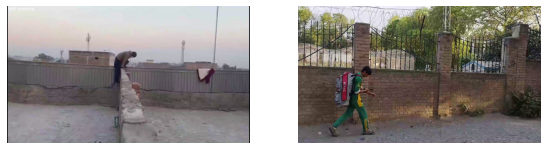

In [12]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in Cricket vedios.
all_classes_names = os.listdir("train")

# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 2)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'train/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'train/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

## Preprocess the Dataset

In [13]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

### Create a Function to Extract, Resize & Normalize Frames 

In [14]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

### Create a Function for Dataset Creation

In [15]:
def create_dataset(DATASET_DIR):
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

### Now we will utilize the function **`create_dataset()`** created above to extract the data of the selected classes and create the required dataset.

In [52]:
# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "train"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ['Normal class','Wall Crossing']

In [53]:
# Create the dataset.
print("load train data")
features_train, labels_train, video_files_paths_train = create_dataset(DATASET_DIR)

load train data
Extracting Data of Class: Normal class
Extracting Data of Class: Wall Crossing


In [16]:
# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "test"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ['Normal class','Wall Crossing']

In [17]:
# Create the dataset.
print("load test data")
features_test, labels_test, video_files_paths_test = create_dataset(DATASET_DIR)

load test data
Extracting Data of Class: Normal class
Extracting Data of Class: Wall Crossing


In [ ]:
print(labels_train.shape)

In [19]:
print(labels_test.shape)

(116,)


### Now we will convert `labels` (class indexes) into one-hot encoded vectors.

### Now we will convert `labels` (class indexes) into one-hot encoded vectors.

In [58]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
labels_train_ = to_categorical(labels_train)

In [20]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
labels_test = to_categorical(labels_test)

## Split the Data into Train and Test Set

In [60]:
"""# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features_train, one_hot_encoded_labels,
                                                                            test_size = 0.25,
                                                                            random_state = seed_constant)"""

'# Split the Data into Train ( 75% ) and Test Set ( 25% ).\nfeatures_train, features_test, labels_train, labels_test = train_test_split(features_train, one_hot_encoded_labels,\n                                                                            test_size = 0.25,\n                                                                            random_state = seed_constant)'

## Implement the ConvLSTM Approach

In [21]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "sigmoid"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

### Now we will utilize the function **`create_convlstm_model()`** created above, to construct the required `convlstm` model.

In [22]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 20, 31, 31, 4)     0         
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 31, 31, 4)     0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 20, 15, 15, 8)     0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 15, 15, 8)     0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 20, 13, 13, 14)    1

#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**


Now we will use the **`plot_model()`** function, to check the structure of the constructed model, this is helpful while constructing a complex network and making that the network is created correctly.

In [63]:
# Plot the structure of the contructed model.
#plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### Compile & Train the Model

In [64]:
# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
history=convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train_, epochs = 10, batch_size = 64,
                                                     validation_split = 0.20)

Train on 364 samples, validate on 92 samples
Epoch 1/10
364/364 [==============================] - 167s 459ms/sample - loss: 0.6584 - acc: 0.6332 - val_loss: 1.1911 - val_acc: 0.0000e+00
Epoch 2/10
364/364 [==============================] - 153s 421ms/sample - loss: 0.6075 - acc: 0.6264 - val_loss: 0.9255 - val_acc: 0.0000e+00
Epoch 3/10
364/364 [==============================] - 152s 416ms/sample - loss: 0.5820 - acc: 0.6429 - val_loss: 1.0378 - val_acc: 0.3370
Epoch 4/10
364/364 [==============================] - 150s 413ms/sample - loss: 0.5116 - acc: 0.8146 - val_loss: 0.9176 - val_acc: 0.5217
Epoch 5/10
364/364 [==============================] - 151s 415ms/sample - loss: 0.4111 - acc: 0.8269 - val_loss: 0.3509 - val_acc: 0.7935
Epoch 6/10
364/364 [==============================] - 149s 411ms/sample - loss: 0.2929 - acc: 0.8846 - val_loss: 0.2730 - val_acc: 0.9239
Epoch 7/10
364/364 [==============================] - 150s 412ms/sample - loss: 0.1651 - acc: 0.9451 - val_loss: 0.1627

#### **<font style="color:rgb(134,19,348)">Evaluate the Trained Model</font>**

After training, we will evaluate the model on the test set.

In [23]:
print(features_test.shape)
print(labels_test.shape)

(116, 20, 64, 64, 3)
(116, 2)


In [33]:
 #Evaluate the trained model
history1= convlstm_model.evaluate(features_test, labels_test)


4/4 [==============================] - 5s 998ms/step - loss: 0.0662 - accuracy: 0.9741


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

Now we will save the model to avoid training it from scratch every time we need the model.

In [67]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = history1

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

### **<font style="color:rgb(134,19,348)">Step 4.3: Plot Model’s Loss & Accuracy Curves</font>**


Now we will create a function **`plot_metric()`** to visualize the training and validation metrics. We already have separate metrics from our training and validation steps so now we just have to visualize them.

In [68]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

Now we will utilize the function **`plot_metric()`** created above, to visualize and understand the metrics.

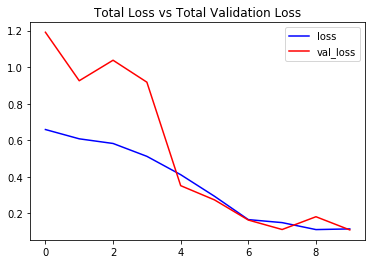

In [69]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

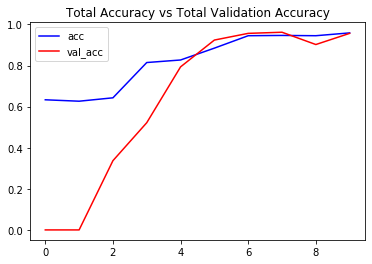

In [70]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'acc', 'val_acc', 'Total Accuracy vs Total Validation Accuracy') 

In [8]:
# features_train, features_test, labels_train, labels_test


y_pred=convlstm_model.predict(features_test)


NameError: name 'features_test' is not defined

In [35]:
labels_aa=[np.argmax(x) for x in labels_test]
len(labels_aa)

116

In [36]:
y_pred_aa=[np.argmax(x) for x in y_pred]
len(y_pred_aa)

116

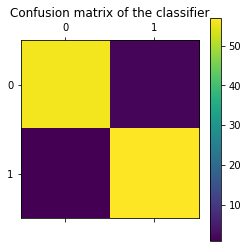

In [37]:
# confusion_matrix(y_true, y_pred)
import matplotlib.pyplot as pl
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_aa, y_pred_aa)
pl.matshow(cm)
pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()

In [18]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


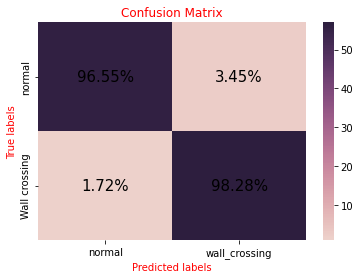

In [64]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the confusion matrix values
cm = np.array([[56, 2],
               [1, 57]])

# Calculate the total number of samples in the dataset
total_samples = np.sum(cm)

# Calculate the percentages
tp_rate = 100 * 56 / 58 #56 / (56 + 2) * 100
fp_rate = 2 * 100 / 58
tn_rate = 1 * 100 / 58
precision = 100 * 57 / 58
f1_score = 2 * (0.9655 * 0.4956) / (0.9655 + 0.4956) * 100

# Create a list of the percentages
percentages = [tp_rate, fp_rate, tn_rate, precision, f1_score]

# Plot the confusion matrix as a heatmap with the percentages as annotations
ax = plt.subplot()
sns.heatmap(cm, annot=False, fmt='g', cmap=sns.cubehelix_palette(as_cmap=True), ax=ax)
# sns.color_palette("rocket", as_cmap=True)
for i, percentage in enumerate(percentages[:-1]):
    text = ax.text(i % 2 + 0.5, i // 2 + 0.5, f'{percentage:.2f}%',
                   ha='center', va='center', color='black', fontsize=15)
ax.set_xlabel('Predicted labels').set_color('red')
ax.set_ylabel('True labels').set_color('red')
ax.set_title('Confusion Matrix').set_color('red')
ax.xaxis.set_ticklabels(['normal', 'wall_crossing'])
ax.yaxis.set_ticklabels(['normal', 'Wall crossing'])
plt.show()

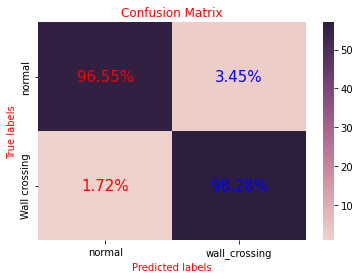

In [65]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the confusion matrix values
cm = np.array([[56, 2],
               [1, 57]])

# Calculate the total number of samples in the dataset
total_samples = np.sum(cm)

# Calculate the percentages
tp_rate = 100 * 56 / 58 #56 / (56 + 2) * 100
fp_rate = 2 * 100 / 58
tn_rate = 1 * 100 / 58
precision = 100 * 57 / 58
f1_score = 2 * (0.9655 * 0.4956) / (0.9655 + 0.4956) * 100

# Create a list of the percentages
percentages = [tp_rate, fp_rate, tn_rate, precision, f1_score]

# Define the colors for the diagonal text annotations
colors = ['r', 'b']

# Plot the confusion matrix as a heatmap with the percentages as annotations
ax = plt.subplot()
sns.heatmap(cm, annot=False, fmt='g', cmap=sns.cubehelix_palette(as_cmap=True), ax=ax)
# sns.color_palette("rocket", as_cmap=True)
for i, percentage in enumerate(percentages[:-1]):
    text = ax.text(i % 2 + 0.5, i // 2 + 0.5, f'{percentage:.2f}%',
                   ha='center', va='center', color=colors[i%2], fontsize=15)
ax.set_xlabel('Predicted labels').set_color('red')
ax.set_ylabel('True labels').set_color('red')
ax.set_title('Confusion Matrix').set_color('red')
ax.xaxis.set_ticklabels(['normal', 'wall_crossing'])
ax.yaxis.set_ticklabels(['normal', 'Wall crossing'])
plt.show()

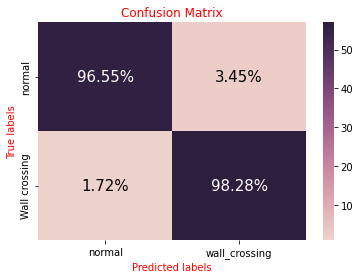

In [75]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the confusion matrix values
cm = np.array([[56, 2],
               [1, 57]])

# Calculate the total number of samples in the dataset
total_samples = np.sum(cm)

# Calculate the percentages
tp_rate = 100 * 56 / 58 #56 / (56 + 2) * 100
fp_rate = 2 * 100 / 58
tn_rate = 1 * 100 / 58
precision = 100 * 57 / 58
f1_score = 2 * (0.9655 * 0.4956) / (0.9655 + 0.4956) * 100

# Create a list of the percentages
percentages = [tp_rate, fp_rate, tn_rate, precision, f1_score]

# Plot the confusion matrix as a heatmap with the percentages as annotations
ax = plt.subplot()
sns.heatmap(cm, annot=False, fmt='g', cmap=sns.cubehelix_palette(as_cmap=True), ax=ax)

# Add color to the annotations
for i, percentage in enumerate(percentages[:-1]):
    if i == 0 or i == 4:
        color = 'white'
    elif i == 2:
        color = 'black'
    elif i == 3:
        color = 'white'
    else:
        color = 'black'
    text = ax.text(i % 2 + 0.5, i // 2 + 0.5, f'{percentage:.2f}%',
                   ha='center', va='center', color=color, fontsize=15)

# Set the color of the axis labels and title
ax.set_xlabel('Predicted labels').set_color('red')
ax.set_ylabel('True labels').set_color('red')
ax.set_title('Confusion Matrix').set_color('red')

# Set the tick labels
ax.xaxis.set_ticklabels(['normal', 'wall_crossing'])
ax.yaxis.set_ticklabels(['normal', 'Wall crossing'])

# Display the plot
plt.show()

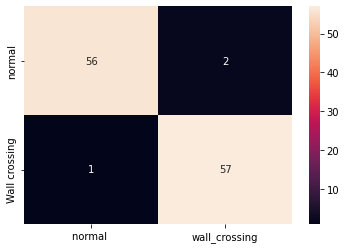

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
# ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['normal ', 'wall_crossing']); ax.yaxis.set_ticklabels(['normal', 'Wall crossing']);

In [16]:
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import confusion_matrix



In [46]:
# accuracy_score(y_pred,real)

print(classification_report(labels_aa,y_pred_aa))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        58
           1       0.97      0.98      0.97        58

    accuracy                           0.97       116
   macro avg       0.97      0.97      0.97       116
weighted avg       0.97      0.97      0.97       116



# Model training Finished^


In [1]:
import tensorflow as tf
import keras

In [2]:
convlstm_model = tf.keras.models.load_model(r"E:\Omair Research data\ConvLstm Finalized trained models With Datasets\SAVED_MODEL__10 EPOCHS_Date_Time_2022_06_19__19_51_00___Loss_0.06623470038175583___Accuracy_0.9741379022598267.h5")

In [3]:
convlstm_model


# Load Model

In [4]:
convlstm_model = tf.keras.models.load_model("E:\Omair Research data\ConvLstm Finalized trained models With Datasets\Omair_saved_trained model\convlstm_model_ 20 epoch___Date_Time_2022_06_27__11_31_20___Loss_0.03814768046140671___Accuracy_0.982758641242981.h5")

In [5]:
convlstm_model